In [41]:
# silly autoreload to avoid restarting the kernel every time
%load_ext autoreload
%autoreload 2

import gc
import time
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from ekf.utils import add_noise_with_snr
from scipy.integrate import odeint

seed = 29
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EKF-SINDy with reaction-diffusion PDE (in POD space)

Consider a reaction-diffusion PDE

$$
\begin{align}
u_t &= 0.1\nabla^2 u +(1-A^2)u + \mu A^2 v,\\
v_t &= 0.1\nabla^2 v - \mu A^2 u + (1 - A^2)v,\\
A^2 &= u^2+v^2.
\end{align}
$$

with a periodic starting condition

$$
\begin{align}
u(x, y,0;\beta)&=\tanh\bigg(\beta\sqrt{x^2+y^2}\cos\bigg(\angle(x+iy)-\beta\sqrt{x^2+y^2}\bigg)\bigg),\\
v(x,y,0;\beta)&=\tanh\bigg(\beta\sqrt{x^2+y^2}\sin\bigg(\angle(x+iy)-\beta\sqrt{x^2+y^2}\bigg)\bigg).

\end{align}
$$

We consider simulations for $\beta=1.1$ and $\mu \in [0.9, 1.3]$. We consider a $\Delta t = 0.05$ with a time window $T=60$. The spatial domain is $[-L, L]^2$ for L = 10, and the spatial step is $\Delta h = 0.4$.

## Selecting POD modes

We extracte the simulated data and compute the top 20 modes. It is well known that the spiral reaction-diffusion PDE is characterized by two oscillating modes. However, these only capture spatial information, hence we must be careful if we try to identify the temporal dynamics with such modes.

Also, the data is not scaled, it does not have unit variance nor zero-mean. Such scaling should be performed during inference as well, with the mean and scaling from the training data.

In [42]:
# Extract data, and stack it

start_t = time.time()

filename = "../../simulation_data/rd_spiral/rd_spiral_mu_0.700_to_1.500_d1_0.01_d2_0.01_m_1_beta_1.1.npz"
data = np.load(filename)

print(f"Data loaded in {time.time() - start_t:.4f} seconds.")

# Reshape data, the third dimension are the number of parameter instances

u = data['u']
v = data['v']
t = u.shape[2]

flat_dim = u.shape[0] * u.shape[1]

mu_instances = u.shape[3]

u_matrix = u.reshape((flat_dim, t * mu_instances))
v_matrix = v.reshape((flat_dim, t * mu_instances))
full_uv = np.vstack((u_matrix, v_matrix))

# # Scaling and zero-centering
# mean_uv = np.mean(full_uv, axis=1, keepdims=True)
# full_uv = full_uv - mean_uv

top_k = 5
start_t = time.time()
U, S, VT = svds(full_uv, k=top_k, which='LM')
U = U[:, ::-1]
S = S[::-1]
print(f"SVD computed in {time.time() - start_t:.4f} seconds.")

# Since the matrix is big, just get rid of them after computing the SVD. We also keep full_uv for later use
full_uv = full_uv.reshape((-1, t, mu_instances))
print(f'full_uv shape: {full_uv.shape}')

del u, v, u_matrix, v_matrix, data
gc.collect()


Data loaded in 0.0020 seconds.
SVD computed in 0.7761 seconds.
full_uv shape: (5000, 801, 6)


82824

Plot the cumulative energy of the modes

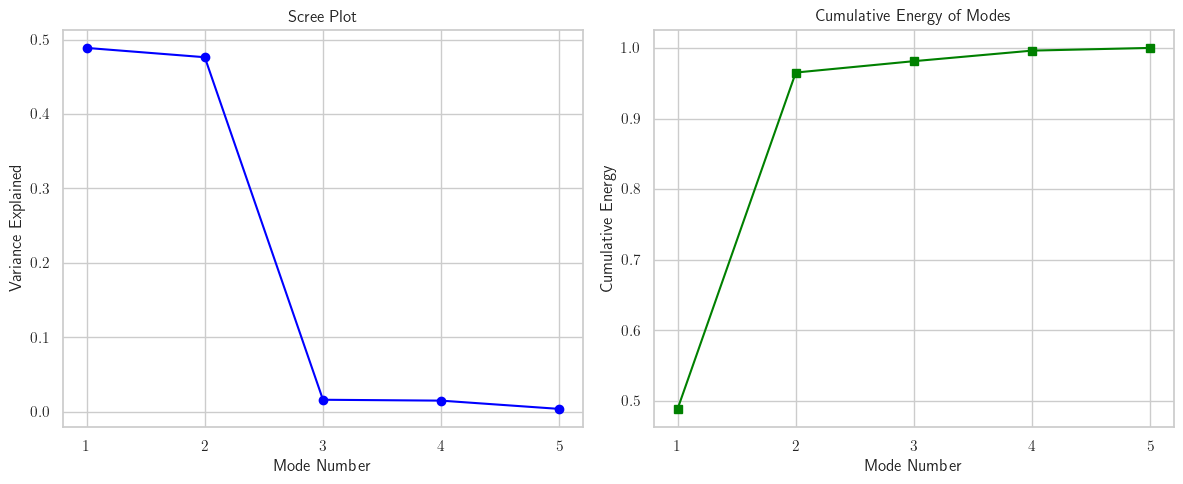

In [43]:
# Singular values
energy = S**2
total_energy = np.sum(energy)
explained_variance = energy / total_energy  # variance explained by each mode
cumulative_energy = np.cumsum(explained_variance)

modes = np.arange(1, len(S)+1)

plt.figure(figsize=(12,5))

# Scree plot
plt.subplot(1,2,1)
plt.plot(modes, explained_variance, 'o-', color='blue')
plt.xlabel('Mode Number')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.grid(True)
plt.xticks(modes)  # Set x-axis ticks to integers

# Cumulative energy
plt.subplot(1,2,2)
plt.plot(modes, cumulative_energy, 's-', color='green')
plt.xlabel('Mode Number')
plt.ylabel('Cumulative Energy')
plt.title('Cumulative Energy of Modes')
plt.grid(True)
plt.xticks(modes)  # Set x-axis ticks to integers

plt.tight_layout()
plt.show()

U[:, :top_k] shape: (5000, 2)


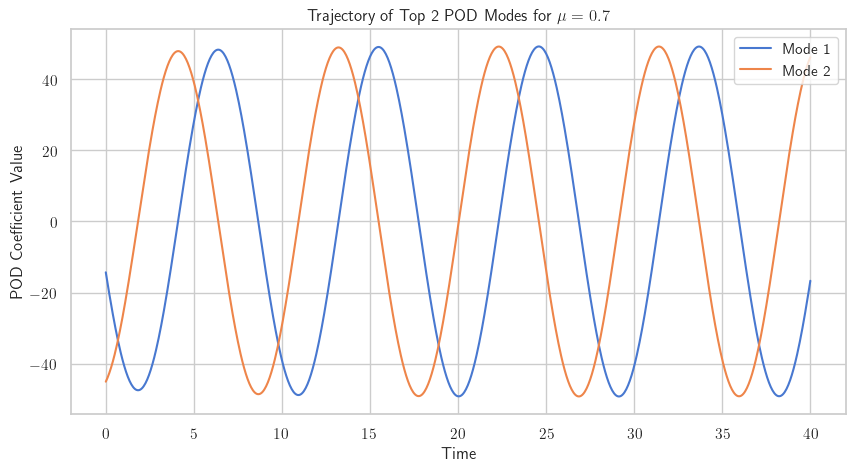

In [59]:
# plot trajectory of top k modes

top_k = 2
t_span = np.arange(0, 40.005, 0.05)

mu_index = 0
pod_projection = full_uv[:, :, mu_index].T @ U[:, :top_k]  # Shape (time, modes)

print(f'U[:, :top_k] shape: {U[:, :top_k].shape}')
# pod_projection = pod_projection.T  # Shape (time, modes)
plt.figure(figsize=(10, 5))
for i in range(top_k):
    plt.plot(t_span, pod_projection[:, i], label=f'Mode {i+1}')
plt.xlabel('Time')
plt.ylabel('POD Coefficient Value')
plt.title('Trajectory of Top 2 POD Modes for $\mu=0.7$')
plt.legend()
plt.grid(True)
plt.show()

Now we would like to identify the dynamics in POD coordinates. First let's take a look at how the top 2 modes evolve. In this case we can also see what SINDy identifies coupled oscillators in POD coordinates, which is very nice, we have very simple dynamics.

In [60]:
# We select the top k modes to feed into SINDy, also we are considering
# 61 parameter instances, each trajectory of length 801
top_k = 2
mu_index = 0
pod_projection = full_uv[:, :, mu_index].T @ U[:, :top_k]

# Now we fit the first parameter instance (corresponding to the zeroth index and mu=0.8)
poly_lib = ps.PolynomialLibrary(degree=3)
fourier_lib = ps.FourierLibrary(n_frequencies=1)
combined_lib = poly_lib + fourier_lib

model = ps.SINDy(feature_library=combined_lib,
                 optimizer=ps.STLSQ(threshold=5e-2),
                 feature_names=[f"z{i}" for i in range(top_k)])

model.fit(pod_projection, t=0.05)
model.print()


(z0)' = 0.691 z1
(z1)' = -0.690 z0


How good is the model?

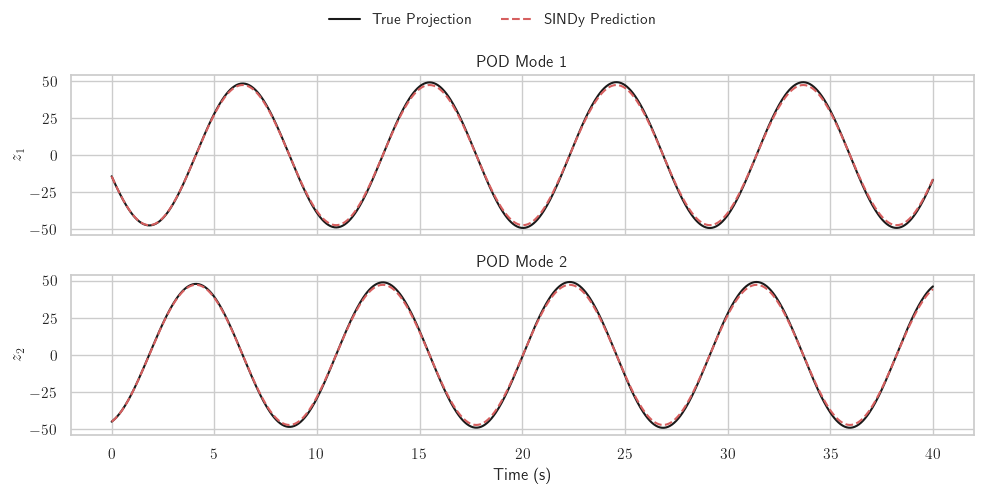

In [46]:
# Solve SINDy model with RK4 
initial_condition = pod_projection[0, :]
rhs = lambda x, t: model.predict(x.reshape(1, -1)).flatten()
sindy_solution = odeint(rhs, initial_condition, t_span)

# Plot SINDy solution vs true projection
fig, axs = plt.subplots(top_k, 1, figsize=(10, 5), sharex=True)

for i in range(top_k):
    axs[i].plot(t_span, pod_projection[:, i], 'k', label='True Projection')
    axs[i].plot(t_span, sindy_solution[:, i], 'r--', label='SINDy Prediction')
    axs[i].set_ylabel(f'$z_{{{i+1}}}$')
    axs[i].set_title(f'POD Mode {i+1}')
    axs[i].grid(True)

axs[-1].set_xlabel('Time (s)')

# Add one shared legend on top
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)

# Adjust layout to leave space for legend
fig.tight_layout(rect=[0, 0, 1, 0.93])

plt.show()

We create the "callback" for preprocessing the observations fed into the filter via POD projection (on the top 2 modes). In our case we already have a PODProjection callback in our library, however, you can define whatever callback you want of course. Maybe even zero-center the incoming observations (using the training mean), up to you. 

We load the data corresponding to our transient and we run the filter on that data. We can there monitor how the coefficients change, and the absolute error w.r.t. actual measurements.

library_terms: ['1', 'z0', 'z1', 'z0^2', 'z0 z1', 'z1^2', 'z0^3', 'z0^2 z1', 'z0 z1^2', 'z1^3', 'sin(1 z0)', 'cos(1 z0)', 'sin(1 z1)', 'cos(1 z1)']
z_test shape: (400, 2), dts shape: (399,)


Processing: 100%|██████████| 399/399 [00:00<00:00, 2445.78it/s]


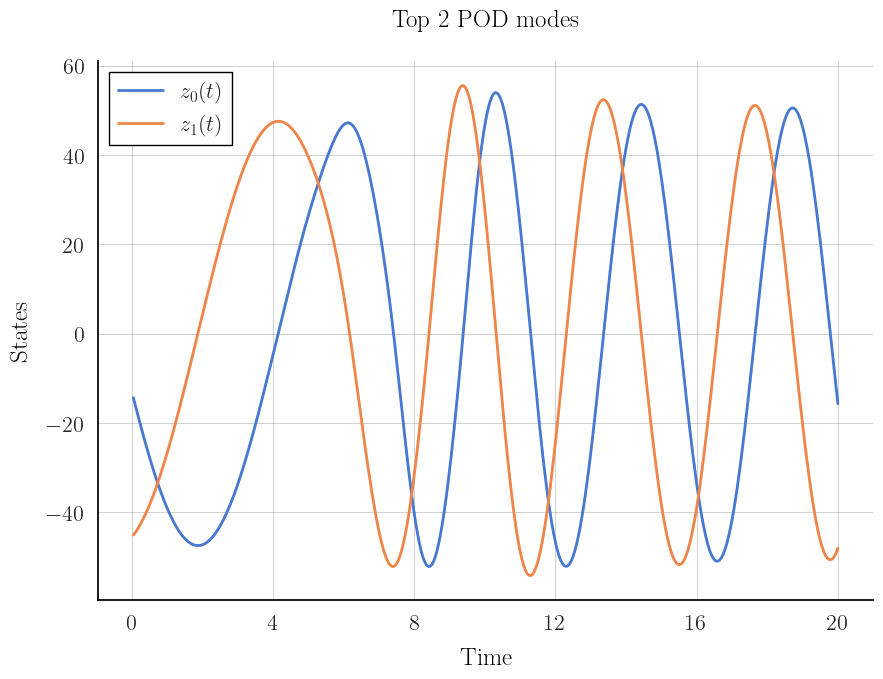

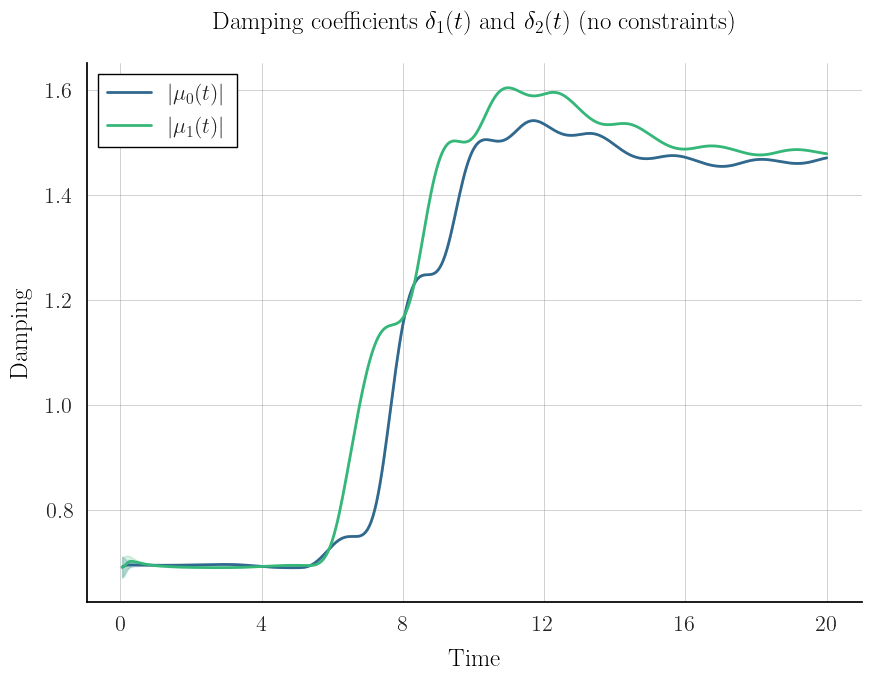

In [68]:
from ekf.filters.ekf import EKF
from ekf.filters.config import DynamicsConfig
from ekf.plotting import plotter

# ekf_callback = PODProjection(pod_modes=U[:, :top_k])
filename = "../../simulation_data/rd_spiral/transient/rd_spiral_transient_mu_0.7_to_1.5_d1_0.01_d2_0.01_m_1.npz"
data = np.load(filename)

# Boring reshaping
u_test, v_test = data['u'], data['v']
flat_dim = u_test.shape[0] * u_test.shape[1]
t_test_length = u_test.shape[2]
full_uv_test = np.vstack((u_test.reshape((flat_dim, t_test_length)),
                           v_test.reshape((flat_dim, t_test_length))))

# Data to be fed to the filter
z_test = (full_uv_test.T @ U[:, :top_k])  # Shape (time, modes)
z0_test = z_test[0, :]
z_test = z_test[1:, :]  # Remove initial condition
time_instances = np.arange(1, t_test_length) * 0.05
dts = np.diff(time_instances)

# EKF configuration (2 POD modes + 2 parameters)
p0 = np.diag([1e-8, 1e-8, 1e-4, 1e-4])  # Initial covariance
q = np.diag([1e-8, 1e-8, 1e-8, 1e-8])  # Process noise covariance
r = np.diag([1e-3, 1e-3])  # Measurement noise covariance

library_terms = model.get_feature_names()
coeffs = model.coefficients()
variables = model.feature_names
print(f'library_terms: {library_terms}')
tracked_terms = [[2],
                 [1]]

# Now we run the filter
config = DynamicsConfig(variables, library_terms, tracked_terms, coeffs, q, r)
filter = EKF(z0_test, p0, config=config, integration_rule='RK4')
print(f'z_test shape: {z_test.shape}, dts shape: {dts.shape}')
filter.run_filter(dts, z_test)

# Plot results

filter_estimates = filter.states.xcal_states[:, :2]
sdevs = filter.states.sdev_states[:, :2]

fig, x = plotter.plot_trajectory(filter_estimates, time_instances, sdevs, x_tick_skip=4, title='Top 2 POD modes', xlabel='Time', ylabel='States',
                                 state_names=["$z_0(t)$", "$z_1(t)$"])

coupling_terms = filter.states.xcal_states[:, 2:]
coupling_sdevs = filter.states.sdev_states[:, 2:]

coupling_terms = np.abs(coupling_terms)

fig, x = plotter.plot_trajectory(coupling_terms, time_instances, coupling_sdevs, x_tick_skip=4, title="Damping coefficients $\delta_1(t)$ and $\delta_2(t)$ (no constraints)", xlabel='Time', ylabel='Damping',
                                 state_names=["$|\\mu_0(t)|$", "$|\\mu_1(t)|$"], palette="viridis")



full_uv_test shape: (5000, 401)
abs_error shape before reshaping: (5000, 400)
domain_area: 2500, num_time_instances: 400


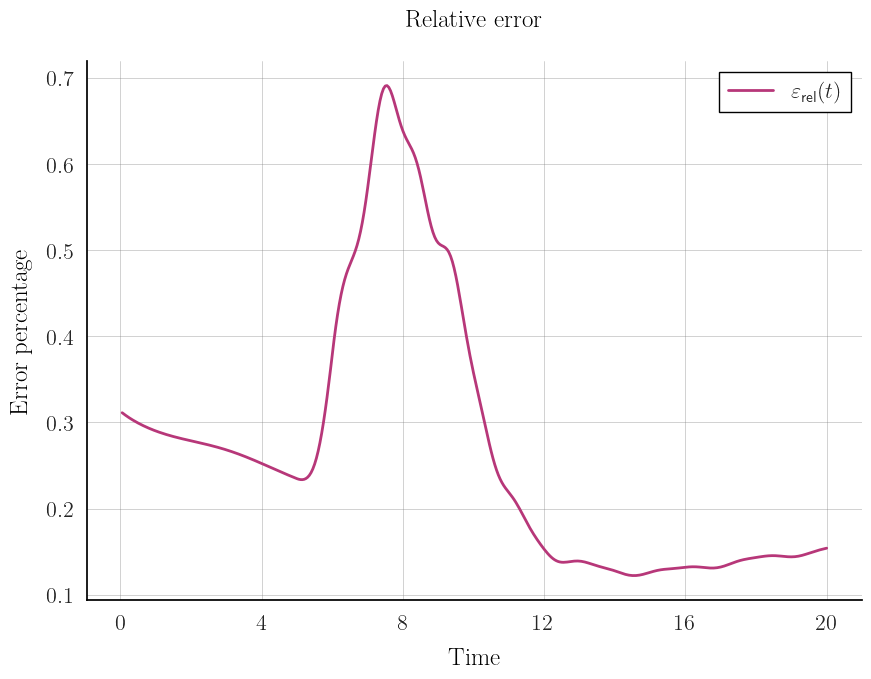

In [67]:
from ekf.filters import error_computation

filter_sol = U[:, :top_k] @ filter.states.xcal_states[:, :top_k].T
print(f'full_uv_test shape: {full_uv_test.shape}')

error_u, error_v, rel_error = error_computation.rd_error(filter_sol, full_uv_test[:, 1:], 50)
rel_error = rel_error.reshape(-1, 1)

fig, x = plotter.plot_trajectory(rel_error.reshape(-1, 1), time_instances, x_tick_skip=4, title="Relative error", xlabel='Time', ylabel='Error percentage',
                                 state_names=["$\\varepsilon_{\\text{rel}}(t)$"], palette="magma")